## Penjelasan Detail Script Analisis Retail & Prediksi ROI

Script Python ini bertujuan untuk menganalisis data penjualan produk retail, mengembangkan fitur-fitur baru (feature engineering) dari data mentah, membangun model Machine Learning untuk memprediksi produk mana yang memiliki potensi ROI (Return on Investment) tinggi, dan akhirnya memberikan rekomendasi bisnis berdasarkan prediksi tersebut.


## 1. Data Loading & Basic Calculation (Pemuatan Data & Perhitungan Dasar)

Bagian pertama ini fokus pada memuat dataset dan melakukan perhitungan awal yang penting:
  - Import Libraries: Mengimpor pustaka yang dibutuhkan seperti pandas untuk manipulasi data, numpy untuk operasi numerik, matplotlib dan seaborn untuk visualisasi, serta modul dari sklearn untuk machine learning.
  - Data Loading: Dataset tbl_roi.csv dimuat dari Google Cloud Storage ke dalam DataFrame df menggunakan pd.read_csv().
  - Basic Financial Metrics:
    - revenue: Dihitung dari unit_price dikalikan units_sold.
    - cost: Dihitung dari unit_cost dikalikan units_sold.
    - refund_loss: Dihitung dari units_refunded dikalikan unit_price.
  - Inventory Logic:
    - understock_flag: Menandai 1 jika terjadi spike (lonjakan) permintaan (spike_flag == 1) dan units_sold melebihi stock_available, yang menunjukkan potensi kehilangan penjualan
    - overstock_flag: Menandai 1 jika stock_available lebih besar dari units_sold, mengindikasikan kelebihan stok.
  - Advanced Inventory Costing:
    - holding_rate: Ditetapkan 0.10 (10%) sebagai biaya penyimpanan.
    - excess_units: Menghitung jumlah unit berlebih jika terjadi overstock_flag.
    - holding_cost: Biaya yang timbul akibat menyimpan unit berlebih, dihitung berdasarkan excess_units, unit_price, holding_rate, dan restock_lead_days.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ==========================================
# 1. DATA LOADING & BASIC CALCULATION
# ==========================================
df = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/komdigi/tbl_roi.csv')

# Basic Financial Metrics
df['revenue'] = df['unit_price'] * df['units_sold']
df['cost'] = df['unit_cost'] * df['units_sold']
df['refund_loss'] = df['units_refunded'] * df['unit_price']

# Inventory Logic (Understock/Overstock)
df['understock_flag'] = (df['spike_flag'] == 1) & (df['units_sold'] > df['stock_available'])
df['overstock_flag'] = df['stock_available'] > df['units_sold']

# Advanced Inventory Costing
# Holding cost sangat penting dalam retail. Barang diam = uang hilang.
holding_rate = 0.10
df['excess_units'] = df.apply(lambda x: max(0, x['stock_available'] - x['units_sold']) if x['overstock_flag'] else 0, axis=1)
df['holding_cost'] = (df['excess_units'] * df['unit_price'] * holding_rate * df['restock_lead_days'])
df.head(5)

,session_date,sku_id,spike_flag,unit_cost,unit_price,units_sold,units_refunded,stock_available,restock_lead_days,revenue,cost,refund_loss,understock_flag,overstock_flag,excess_units,holding_cost
0,2025-01-01,DQProduk-001,0,149850.0,239850.0,12,0,109,2,2878200.0,1798200.0,0.0,False,True,97,4653090.0
1,2025-01-02,DQProduk-001,1,149850.0,239850.0,24,5,163,1,5756400.0,3596400.0,1199250.0,False,True,139,3333915.0
2,2025-01-03,DQProduk-001,0,149850.0,239850.0,9,0,67,3,2158650.0,1348650.0,0.0,False,True,58,4173390.0
3,2025-01-04,DQProduk-001,0,149850.0,239850.0,8,0,125,3,1918800.0,1198800.0,0.0,False,True,117,8418735.0
4,2025-01-05,DQProduk-001,0,149850.0,239850.0,7,1,76,3,1678950.0,1048950.0,239850.0,False,True,69,4964895.0


## 2. Advanced Retail Feature Engineering (Rekayasa Fitur Retail Lanjutan)

Bagian ini menciptakan fitur-fitur baru yang lebih kompleks dan bermakna untuk model:
- A. Efficiency Metrics:
  - sell_through_rate: Mengukur seberapa cepat stok terjual, dihitung sebagai units_sold dibagi (units_sold + stock_available). Nilai 0,1 ditambahkan pada (units_sold + stock_available) untuk menghindari pembagian dengan nol.
- B. Stock Health:
  - stock_cover_ratio: Menunjukkan berapa lama stok yang ada dapat menutupi penjualan, dihitung sebagai stock_available dibagi units_sold. Nilai 0,1 ditambahkan pada units_sold untuk menghindari pembagian dengan nol.
- C. Profitability Drivers:
  - unit_margin_ratio: Mengukur margin keuntungan per unit relatif terhadap harga jual.
  - refund_rate: Menghitung persentase unit yang dikembalikan relatif terhadap unit yang terjual. Nilai 0,1 ditambahkan pada units_sold untuk menghindari pembagian dengan nol.
- D. Supply Chain Risk Interaction:
  - lead_time_risk: Menggabungkan risiko dari restock_lead_days (lama waktu restock) dengan spike_flag (lonjakan permintaan). Jika waktu tunggu restock lama dan ada lonjakan permintaan, risiko akan tinggi.


In [6]:
# ==========================================
# 2. ADVANCED RETAIL FEATURE ENGINEERING
# ==========================================

# A. Efficiency Metrics
# Sell-Through Rate: Seberapa cepat kita menghabiskan stok yang tersedia? (0-100%)
# Rumus: Units Sold / (Units Sold + Stock Available) -> Asumsi Stock Available adalah sisa ending inventory
df['total_stock_on_hand'] = df['units_sold'] + df['stock_available']
df['sell_through_rate'] = df['units_sold'] / df['total_stock_on_hand'].replace(0, 1)

# B. Stock Health
# Stock Cover Ratio: Berapa kali stok kita bisa menutupi penjualan?
# Jika rasionya terlalu tinggi = Overstock, terlalu rendah = Risk of Out of Stock
df['stock_cover_ratio'] = df['stock_available'] / df['units_sold'].replace(0, 1)

# C. Profitability Drivers
# Unit Margin Ratio: Seberapa besar margin per unit dibandingkan harga jual?
df['unit_margin_ratio'] = (df['unit_price'] - df['unit_cost']) / df['unit_price']

# Refund Rate Impact
df['refund_rate'] = df['units_refunded'] / df['units_sold'].replace(0, 1)

# D. Supply Chain Risk Interaction
# Spike Risk: Jika lead time lama DAN ada spike demand, ini risiko tinggi.
df['lead_time_risk'] = df['restock_lead_days'] * df['spike_flag']
df.head(5)

,session_date,sku_id,spike_flag,unit_cost,unit_price,units_sold,units_refunded,stock_available,restock_lead_days,revenue,...,understock_flag,overstock_flag,excess_units,holding_cost,total_stock_on_hand,sell_through_rate,stock_cover_ratio,unit_margin_ratio,refund_rate,lead_time_risk
0,2025-01-01,DQProduk-001,0,149850.0,239850.0,12,0,109,2,2878200.0,...,False,True,97,4653090.0,121,0.099174,9.083333,0.375235,0.000000,0
1,2025-01-02,DQProduk-001,1,149850.0,239850.0,24,5,163,1,5756400.0,...,False,True,139,3333915.0,187,0.128342,6.791667,0.375235,0.208333,1
2,2025-01-03,DQProduk-001,0,149850.0,239850.0,9,0,67,3,2158650.0,...,False,True,58,4173390.0,76,0.118421,7.444444,0.375235,0.000000,0
3,2025-01-04,DQProduk-001,0,149850.0,239850.0,8,0,125,3,1918800.0,...,False,True,117,8418735.0,133,0.060150,15.625000,0.375235,0.000000,0
4,2025-01-05,DQProduk-001,0,149850.0,239850.0,7,1,76,3,1678950.0,...,False,True,69,4964895.0,83,0.084337,10.857143,0.375235,0.142857,0


## 3. Target Definition (ROI Class) (Definisi Target Kelas ROI)

Bagian ini mendefinisikan variabel target yang akan diprediksi oleh model:
- Menghitung Real ROI:
  - net_profit: Dihitung sebagai revenue - cost - refund_loss - holding_cost.
  - total_investment: Disimplifikasi berdasarkan cost
  - roi_value_net: Dihitung sebagai (net_profit / total_investment) * 100.
- Target Class:
  - roi_class: Variabel biner (0 atau 1) yang menjadi target prediksi. Nilainya 1 jika roi_value_net >= 20% (dianggap ROI tinggi), dan 0 jika kurang dari 20% (ROI rendah).


In [8]:
# ==========================================
# 3. TARGET DEFINITION (ROI CLASS)
# ==========================================
# Menghitung Real ROI (Net Profit / Cost)
# Net Profit = Revenue - COGS - Refund Loss - Holding Cost
net_profit = df['revenue'] - df['cost'] - df['refund_loss'] - df['holding_cost']
total_investment = df['cost'] # Simplifikasi investment based on COGS

df['roi_value_net'] = (net_profit / total_investment.replace(0, 1)) * 100

# Target Class: 1 jika ROI >= 20%, else 0
df['roi_class'] = (df['roi_value_net'] >= 20).astype(int)
df.head(5)

,session_date,sku_id,spike_flag,unit_cost,unit_price,units_sold,units_refunded,stock_available,restock_lead_days,revenue,...,excess_units,holding_cost,total_stock_on_hand,sell_through_rate,stock_cover_ratio,unit_margin_ratio,refund_rate,lead_time_risk,roi_value_net,roi_class
0,2025-01-01,DQProduk-001,0,149850.0,239850.0,12,0,109,2,2878200.0,...,97,4653090.0,121,0.099174,9.083333,0.375235,0.000000,0,-198.703704,0
1,2025-01-02,DQProduk-001,1,149850.0,239850.0,24,5,163,1,5756400.0,...,139,3333915.0,187,0.128342,6.791667,0.375235,0.208333,1,-65.987237,0
2,2025-01-03,DQProduk-001,0,149850.0,239850.0,9,0,67,3,2158650.0,...,58,4173390.0,76,0.118421,7.444444,0.375235,0.000000,0,-249.389389,0
3,2025-01-04,DQProduk-001,0,149850.0,239850.0,8,0,125,3,1918800.0,...,117,8418735.0,133,0.060150,15.625000,0.375235,0.000000,0,-642.203453,0
4,2025-01-05,DQProduk-001,0,149850.0,239850.0,7,1,76,3,1678950.0,...,69,4964895.0,83,0.084337,10.857143,0.375235,0.142857,0,-436.126126,0


## 4. Modeling with Hyperparameter Tuning (Pemodelan dengan Penyetelan Hyperparameter)

Pada tahap ini, model Machine Learning dibangun dan dioptimalkan:
- Feature Selection: feature_cols dipilih sebagai fitur (X) yang akan digunakan untuk melatih model, sedangkan roi_class adalah target (y).
- Data Splitting: Data dibagi menjadi set pelatihan (80%) dan set pengujian (20%) menggunakan train_test_split dengan random_state=42 untuk reproduktibilitas dan stratify=y untuk menjaga distribusi kelas target tetap seimbang di kedua set.
- Random Forest Classifier: Sebuah model RandomForestClassifier diinisialisasi. class_weight='balanced' digunakan untuk menangani ketidakseimbangan kelas (jika jumlah produk ROI tinggi dan rendah berbeda jauh).
- Hyperparameter Tuning (GridSearchCV):
  - param_grid: Menentukan rentang hyperparameter yang akan diuji (n_estimators, max_depth, min_samples_leaf).
  - GridSearchCV: Melakukan pencarian menyeluruh (exhaustive search) untuk menemukan kombinasi hyperparameter terbaik yang menghasilkan metrik f1 tertinggi (karena f1 baik untuk kelas yang tidak seimbang) melalui validasi silang (cross-validation) sebanyak 3 lipatan (cv=3).
  - best_model: Model dengan hyperparameter terbaik disimpan
  - Output akan menampilkan Best Parameters yang ditemukan.


In [9]:
# ==========================================
# 4. MODELING WITH HYPERPARAMETER TUNING
# ==========================================

# Fitur yang lebih kaya untuk prediksi
feature_cols = [
    'stock_available', 'unit_margin_ratio', 'refund_rate',
    'restock_lead_days', 'sell_through_rate', 'stock_cover_ratio',
    'lead_time_risk', 'unit_price'
]

X = df[feature_cols]
y = df['roi_class']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest dengan Hyperparameter Tuning sederhana
# Ini mencegah overfitting dan mencari setting terbaik
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4]
}

print("Sedang melakukan tuning model (GridSearch)... mohon tunggu sebentar.")
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_params_}")

Sedang melakukan tuning model (GridSearch)... mohon tunggu sebentar.
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}


## 5. Evaluation & Visualization (Evaluasi & Visualisasi)
Bagian ini mengevaluasi kinerja model dan memvisualisasikan hasilnya:
- Prediction: Model terbaik (best_model) digunakan untuk membuat prediksi pada data uji (X_test).
- Classification Report: Menampilkan metrik evaluasi penting seperti precision, recall, dan f1-score untuk setiap kelas (0 dan 1), serta akurasi keseluruhan. Ini memberikan gambaran detail tentang kinerja model.
- ROC-AUC Score: Menghitung dan menampilkan Receiver Operating Characteristic - Area Under Curve (ROC-AUC) score. Ini adalah metrik yang sangat baik untuk model klasifikasi biner, terutama ketika kelas tidak seimbang, karena mengukur kemampuan model untuk membedakan antara kelas positif dan negatif.
- Feature Importance Visualization:
  - Menggunakan best_model.feature_importances_ untuk mendapatkan seberapa besar kontribusi setiap fitur dalam membuat prediksi
  - Membuat bar plot (sns.barplot) untuk menampilkan fitur-fitur terpenting, membantu mengidentifikasi faktor-faktor kunci yang mempengaruhi ROI.
- Confusion Matrix Visualization:
  - Menghitung confusion_matrix yang menunjukkan jumlah prediksi benar dan salah untuk setiap kelas.
  - Membuat heatmap (sns.heatmap) dari confusion matrix untuk visualisasi yang mudah dipahami, menunjukkan di mana model berhasil dan di mana ia melakukan kesalahan (misalnya, berapa banyak produk ROI tinggi yang salah diprediksi sebagai ROI rendah).



--- Classification Report (Enhanced) ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       584
           1       0.78      0.91      0.84        46

    accuracy                           0.97       630
   macro avg       0.89      0.95      0.91       630
weighted avg       0.98      0.97      0.98       630

ROC-AUC Score: 0.9462


/tmp/ipython-input-3375437646.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=[feature_cols[i] for i in indices], palette="viridis")


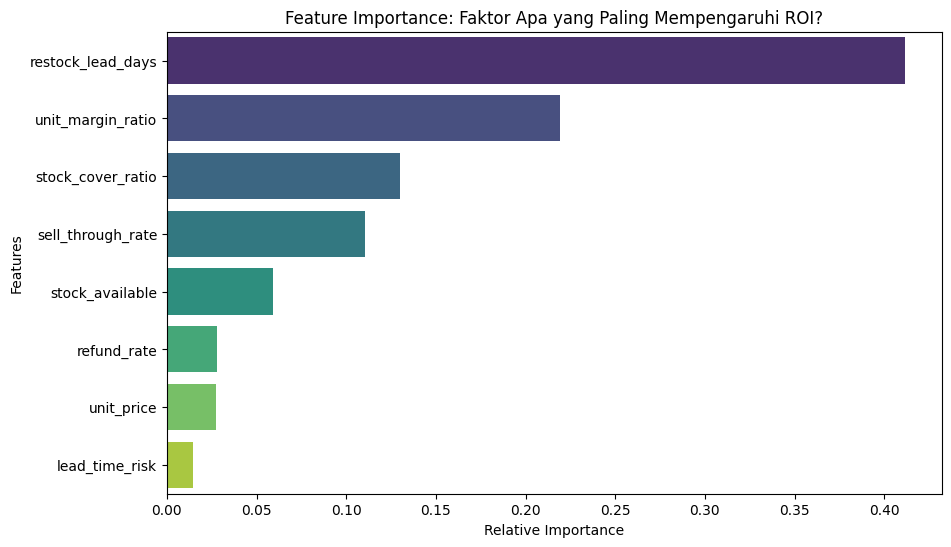

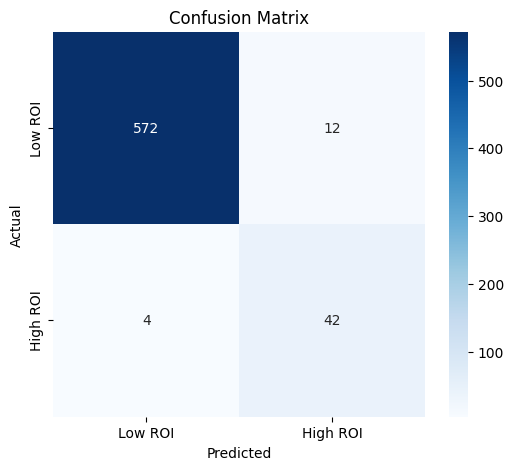

In [10]:
# ==========================================
# 5. EVALUATION & VISUALIZATION
# ==========================================
y_pred = best_model.predict(X_test)

print("\n--- Classification Report (Enhanced) ---")
print(classification_report(y_test, y_pred))

# Hitung ROC-AUC Score (Metric yang lebih baik untuk keseimbangan)
roc_score = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC Score: {roc_score:.4f}")

# Visualisasi Feature Importance
# Ini sangat penting bagi manajemen retail untuk mengetahui 'Driver' profit
plt.figure(figsize=(10, 6))
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

sns.barplot(x=importances[indices], y=[feature_cols[i] for i in indices], palette="viridis")
plt.title('Feature Importance: Faktor Apa yang Paling Mempengaruhi ROI?')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low ROI', 'High ROI'], yticklabels=['Low ROI', 'High ROI'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### Interpretasi Hasil Classification Report

1. Executive Summary (Kesimpulan Utama)
  - Akurasi 97%: Secara umum, model ini hampir selalu benar
    - ROC-AUC 0.95 (0.9462): Ini adalah skor "A+". Kemampuan model untuk membedakan mana produk "Sampah" (Low ROI) dan mana produk "Emas" (High ROI) sangat tajam.
    - Handling Imbalance: Model berhasil mengatasi masalah data yang timpang. Biasanya, pada data seperti ini, model akan menebak "0" semua dan mendapatkan akurasi tinggi tapi Recall 0 untuk kelas 1. Model Anda tidak terjebak di sana.

2. Deep Dive: Kelas 1 (High ROI / Produk Unggulan)
Ini adalah kelas yang paling kita pedulikan karena inilah sumber profit.
  - Recall: 0.91 (91%) -> "Opportunity Capture"
    - Artinya: Dari seluruh produk yang benar-benar High ROI di lapangan, model berhasil mendeteksi 91%-nya. Hanya 9% peluang emas yang terlewat.
    - Dampak Bisnis: Anda tidak akan kehilangan momen (FOMO). Hampir semua produk yang berpotensi laku keras sudah masuk radar Anda untuk di-restock.
  - Precision: 0.78 (78%) -> "Trust Level"
    - Artinya: Ketika model berteriak "Ini High ROI!", 78% tebakannya benar, tapi 22% sisanya ternyata meleset (False Positive).
    - Dampak Bisnis: Ada risiko kecil Anda akan over-invest di 22% barang yang diprediksi bagus tapi ternyata biasa saja. Namun, dalam retail, Recall tinggi biasanya lebih penting daripada Precision. Lebih baik kita sedikit kelebihan stok pada barang yang salah, daripada kehabisan stok pada barang yang laku keras (karena cost of lost sales biasanya lebih menyakitkan daripada holding cost).
3. Deep Dive: Kelas 0 (Low ROI / Produk Biasa)
  - Precision 0.99 & Recall 0.98:
    - Artinya: Model ini sangat ruthlessly accurate dalam membuang produk jelek.
    - Dampak Bisnis: Jika model bilang "Jangan restock barang ini," percayalah padanya. Kemungkinan besar barang itu memang akan membebani gudang (Dead Stock). Anda bisa menghemat modal kerja secara signifikan dengan mengikuti saran ini.

4. Rekomendasi Tindakan (Action Plan)
Berdasarkan matriks ini, strategi Anda harusnya:

1.	Untuk Prediksi Class 1 (High ROI):
Lakukan Aggressive Restocking. Karena Precision "hanya" 78%, mungkin tim Procurement bisa melakukan double-check manual sekilas, tapi secara umum lampu hijau untuk beli stok.

2.	Untuk Prediksi Class 0 (Low ROI):
Lakukan Automated Rejection. Jangan habiskan waktu review manual. Jika model bilang jelek, stop order atau lakukan diskon cuci gudang segera.

-----------------------------------------

### Interpretasi Hasil Confussion Matrix

1. True Negatives (Kiri Atas: 572) -> "The Shield"
  - Apa artinya: Ada 572 produk yang sebenarnya jelek (Low ROI) dan model Anda benar memprediksinya jelek.
  - Dampak Bisnis: PENGHEMATAN MODAL BESAR-BESARAN.
    - Model ini berhasil mencegah Anda membeli stok untuk 572 item yang tidak akan menguntungkan. Bayangkan jika Anda membeli item-item ini secara manual, gudang Anda akan penuh dengan barang mati (dead stock).
    - Kesimpulan: Filter otomatis Anda sangat efektif membuang sampah.
2. True Positives (Kanan Bawah: 42) -> "The Gold Mine"
  - Apa artinya: Ada 42 produk yang sebenarnya bagus (High ROI) dan model Anda benar memprediksinya bagus.
  - Dampak Bisnis: PROFIT GENERATOR.
    - Ini adalah produk-produk "bintang". Karena model mendeteksinya dengan benar, tim pengadaan bisa langsung melakukan restock atau negosiasi harga lebih awal. Inilah sumber keuntungan utama Anda.

3. False Positives (Kanan Atas: 12) -> "Investment Trap" (Resiko Overstock)
  - Apa artinya: Ada 12 produk yang sebenarnya jelek, tapi model Anda salah menebaknya sebagai produk bagus.
  - Dampak Bisnis: KERUGIAN BIAYA GUDANG.
    - Anda akan tertipu untuk membeli 12 item ini. Karena ternyata ROI-nya rendah, barang ini mungkin akan lama terjual atau butuh diskon besar nantinya.
    - Mitigasi: Jumlahnya kecil (hanya 12 dari 630 data). Dalam retail, rasio "korban" sekecil ini biasanya dapat diterima (acceptable risk) demi mengejar profit dari True Positives.
4. False Negatives (Kiri Bawah: 4) -> "Missed Opportunity" (Resiko Lost Sales)
  - Apa artinya: Ada 4 produk yang sebenarnya bagus (High ROI), tapi model Anda salah menebaknya sebagai produk jelek.
  - Dampak Bisnis: HILANG POTENSI OMZET (FOMO).
    - Anda melewatkan kesempatan untuk menjual 4 item laris ini karena model menyuruh Anda mengabaikannya.
    - Kabar Baiknya: Angkanya sangat kecil (hanya 4). Ini berarti model Anda memiliki Recall yang tinggi. Model ini sangat "takut" Anda kehilangan peluang emas, sehingga ia jarang sekali melewatkan barang bagus.



## 6. Simulasi Prediksi pada Data Baru (Inference) (Simulasi Prediksi pada Data Baru)

Bagian terakhir ini menunjukkan bagaimana model yang telah dilatih dapat digunakan untuk membuat prediksi pada data produk baru dan memberikan rekomendasi bisnis:
- A. Fungsi preprocess_retail_data:
  - Fungsi ini sangat penting untuk menjaga konsistensi. Ia mengambil data mentah produk baru dan menerapkan langkah-langkah preprocessing dan feature engineering yang sama persis seperti yang dilakukan pada data pelatihan. Ini memastikan bahwa fitur-fitur yang diberikan ke model memiliki format dan arti yang sama.
- B. Membuat Data Dummy:
  - new_products_data: Sebuah dictionary dibuat untuk mensimulasikan data dari 5 produk baru, lengkap dengan informasi seperti harga, biaya, unit terjual, stok, dll.
  - df_new_raw: Dictionary tersebut diubah menjadi DataFrame.
- C. Eksekusi Prediksi:
  - X_new = preprocess_retail_data(df_new_raw): Data produk baru diolah menggunakan fungsi preprocessing.
  - new_predictions = best_model.predict(X_new): Model memprediksi kelas ROI (0 atau 1) untuk produk baru.
  - new_probs = best_model.predict_proba(X_new)[:, 1]: Model juga memprediksi probabilitas bahwa setiap produk termasuk dalam kelas ROI tinggi (1). Ini memberikan 'Confidence Score' atau tingkat keyakinan model.
- D. Menampilkan Hasil dengan Rekomendasi Bisnis:
  - Sebuah DataFrame results dibuat untuk menampilkan sku_id, unit_price, units_sold, Predicted_ROI_Class, dan Confidence_Score.
  - Fungsi get_recommendation: Ini adalah logika inti untuk memberikan rekomendasi bisnis. Berdasarkan Predicted_ROI_Class dan Confidence_Score, fungsi ini memberikan salah satu dari empat rekomendasi:
  - STAR PRODUCT: Jika diprediksi ROI tinggi (kelas 1) dengan Confidence_Score di atas ambang batas tertentu (default 80%).
  - POTENTIAL: Jika diprediksi ROI tinggi tetapi Confidence_Score tidak mencapai ambang batas STAR PRODUCT (menyarankan pemantauan lebih lanjut).
  - DEAD STOCK: Jika diprediksi ROI rendah (kelas 0) dengan Confidence_Score di bawah ambang batas tertentu (default 20%).
  - EVALUATE: Untuk kasus lain yang memerlukan evaluasi lebih lanjut.
- results['Action_Recommendation'] = results.apply(get_recommendation, axis=1): Rekomendasi diterapkan ke setiap baris produk baru.
- Output Hasil: Tabel hasil prediksi dan rekomendasi ditampilkan dengan rapi. Selain itu, ringkasan jumlah produk yang diprediksi memiliki ROI tinggi juga ditampilkan.


In [11]:
# ==========================================
# 6. SIMULASI PREDIKSI PADA DATA BARU (INFERENCE)
# ==========================================

print("\n--- Memulai Simulasi Prediksi Data Baru ---")

# A. Fungsi Preprocessing (Pipeline Konsistensi)
# Fungsi ini memastikan data baru diperlakukan sama persis dengan data training
def preprocess_retail_data(raw_df):
    df_new = raw_df.copy()

    # 1. Basic Metrics
    df_new['revenue'] = df_new['unit_price'] * df_new['units_sold']
    df_new['cost'] = df_new['unit_cost'] * df_new['units_sold']

    # 2. Inventory Logic
    df_new['understock_flag'] = (df_new['spike_flag'] == 1) & (df_new['units_sold'] > df_new['stock_available'])
    df_new['overstock_flag'] = df_new['stock_available'] > df_new['units_sold']

    # 3. Efficiency Metrics (Feature Engineering)
    df_new['total_stock_on_hand'] = df_new['units_sold'] + df_new['stock_available']
    df_new['sell_through_rate'] = df_new['units_sold'] / df_new['total_stock_on_hand'].replace(0, 1)
    df_new['stock_cover_ratio'] = df_new['stock_available'] / df_new['units_sold'].replace(0, 1)
    df_new['unit_margin_ratio'] = (df_new['unit_price'] - df_new['unit_cost']) / df_new['unit_price']
    df_new['refund_rate'] = df_new['units_refunded'] / df_new['units_sold'].replace(0, 1)
    df_new['lead_time_risk'] = df_new['restock_lead_days'] * df_new['spike_flag']

    # Pastikan hanya kolom feature yang dipakai model yang dikembalikan
    # feature_cols harus sama dengan yang didefinisikan di tahap training
    return df_new[feature_cols] # Mengambil global variable feature_cols dari tahap sebelumnya

# B. Membuat Data Dummy (Skenario Produk Baru)
# Bayangkan ini adalah laporan penjualan minggu pertama dari 5 SKU baru
new_products_data = {
    'sku_id': ['NEW-001', 'NEW-002', 'NEW-003', 'NEW-004', 'NEW-005'],
    'unit_price': [150000, 500000, 75000, 1200000, 250000],
    'unit_cost': [80000, 450000, 40000, 800000, 150000],
    'units_sold': [120, 10, 500, 5, 80],
    'stock_available': [20, 200, 50, 10, 100],
    'units_refunded': [2, 1, 10, 0, 15],
    'restock_lead_days': [7, 30, 3, 14, 7],
    'spike_flag': [1, 0, 1, 0, 0]
}

df_new_raw = pd.DataFrame(new_products_data)

# C. Eksekusi Prediksi
# 1. Olah data mentah menjadi features
X_new = preprocess_retail_data(df_new_raw)

# 2. Prediksi Kelas (0 = Low ROI, 1 = High ROI)
new_predictions = best_model.predict(X_new)

# 3. Prediksi Probabilitas (Seberapa yakin model?)
# Ini penting untuk mitigasi risiko. Prediksi 1 dengan probabilitas 51% vs 90% itu beda.
new_probs = best_model.predict_proba(X_new)[:, 1]

# D. Menampilkan Hasil dengan Rekomendasi Bisnis
results = df_new_raw[['sku_id', 'unit_price', 'units_sold']].copy()
results['Predicted_ROI_Class'] = new_predictions
results['Confidence_Score'] = (new_probs * 100).round(2)

# Logic sederhana untuk rekomendasi otomatis
def get_recommendation(row):
    if row['Predicted_ROI_Class'] == 1 and row['Confidence_Score'] > 80:
        return "STAR PRODUCT: Restock Segera & Boost Ads"
    elif row['Predicted_ROI_Class'] == 1:
        return "POTENTIAL: Monitor Margin"
    elif row['Predicted_ROI_Class'] == 0 and row['Confidence_Score'] < 20:
        return "DEAD STOCK: Diskon/Cuci Gudang"
    else:
        return "EVALUATE: Cek Biaya Operasional"

results['Action_Recommendation'] = results.apply(get_recommendation, axis=1)

print("\n--- Hasil Analisa Produk Baru ---")
# Menampilkan tabel hasil dengan rapi
import tabulate # Opsional, jika error cukup print biasa
try:
    print(results.to_markdown(index=False))
except:
    print(results)

# Insight Cepat
high_roi_count = results['Predicted_ROI_Class'].sum()
print(f"\nKesimpulan: Dari {len(results)} produk baru, {high_roi_count} diprediksi memberikan ROI tinggi.")


--- Memulai Simulasi Prediksi Data Baru ---

--- Hasil Analisa Produk Baru ---
| sku_id   |   unit_price |   units_sold |   Predicted_ROI_Class |   Confidence_Score | Action_Recommendation           |
|:---------|-------------:|-------------:|----------------------:|-------------------:|:--------------------------------|
| NEW-001  |       150000 |          120 |                     0 |              35.33 | EVALUATE: Cek Biaya Operasional |
| NEW-002  |       500000 |           10 |                     0 |               0    | DEAD STOCK: Diskon/Cuci Gudang  |
| NEW-003  |        75000 |          500 |                     1 |              64.29 | POTENTIAL: Monitor Margin       |
| NEW-004  |      1200000 |            5 |                     0 |               3.25 | DEAD STOCK: Diskon/Cuci Gudang  |
| NEW-005  |       250000 |           80 |                     0 |              33.16 | EVALUATE: Cek Biaya Operasional |

Kesimpulan: Dari 5 produk baru, 1 diprediksi memberikan ROI tingg

## Interpretasi Grafik Feature Importance

1. Raja Sebenarnya: restock_lead_days (Supply Chain Speed)
Faktor ini mendominasi grafik dengan skor tertinggi (>0.40).
  - Apa Artinya: Kecepatan supplier mengirim barang adalah penentu utama apakah produk itu untung (High ROI) atau buntung.
  - Business Logic:
    - Lead time yang lama = Risiko Stockout saat barang laku keras (hilang omzet).
    - Lead time yang lama = Harus simpan Safety Stock besar (biaya gudang bengkak).
    - Action Plan: Jangan hanya menekan harga beli ke supplier. Tekan waktu pengiriman. Supplier yang harganya sedikit lebih mahal tapi bisa kirim dalam 3 hari mungkin memberikan ROI jauh lebih baik daripada supplier murah yang butuh waktu 30 hari.

2. Profitabilitas Murni: unit_margin_ratio
Faktor kedua terpenting.
  - Apa Artinya: Model mengonfirmasi bahwa seberapa besar selisih harga jual dan harga modal (persentase margin) sangat krusial.
  - Business Logic: Produk dengan Sell-Through tinggi tidak akan menolong ROI jika marginnya tipis (seperti menjual beras atau pulsa, volume besar tapi untung tipis).
  - Action Plan: Review COGS (Cost of Goods Sold). Fokuskan negosiasi pada produk-produk yang margin rasionya di bawah standar perusahaan.

3. Kesehatan Stok: stock_cover_ratio & sell_through_rate
Berada di posisi ke-3 dan ke-4.
  - Apa Artinya: Ini adalah metrik efisiensi. Seberapa cepat barang keluar dibanding barang yang diam.
  - Business Logic:
    - stock_cover_ratio: Jika stok menumpuk terlalu banyak dibanding penjualan, ROI hancur karena uang "mati" di gudang.
    - sell_through_rate: Produk yang cepat habis (turnover tinggi) meningkatkan Cash Flow.
    - Action Plan: Identifikasi produk dengan stock cover tinggi tapi sell-through rendah. Itu adalah kandidat utama untuk didiskon (cuci gudang) agar uangnya bisa diputar ke produk lain.

4. Kejutan: unit_price Tidak Penting!
Perhatikan bahwa unit_price berada di posisi bawah (bar warna hijau muda).
  - Insight: Menjual barang mewah (harga mahal) tidak menjamin ROI tinggi. Menjual barang murah juga tidak menjamin rugi.
  - Pelajaran: Jangan terobsesi dengan "Nilai Transaksi". Fokuslah pada Efisiensi Supply Chain (Lead Time) dan Margin, bukan harga jual nominalnya.

Kesimpulan Strategis untuk Manajemen:
Berdasarkan data ini, jika Anda ingin meningkatkan ROI perusahaan tahun depan, jangan fokus menaikkan harga jual (unit_price).
Sebaliknya, lakukan ini:
1.	Perbaiki Rantai Pasok: Cari cara memangkas restock_lead_days.
2.	Jaga Margin: Pertahankan unit_margin_ratio yang sehat.
3.	Kendalkan Stok: Pastikan stock_cover_ratio tidak berlebihan.
